In [2]:
from __future__ import division

from pylab import *
import scipy
import time

import imnet_utils as imut
import sklearn
from sklearn.decomposition import PCA, FastICA, TruncatedSVD, NMF

%matplotlib inline

plt.rcParams.update({'axes.titlesize': 'xx-large'})
plt.rcParams.update({'axes.labelsize': 'xx-large'})
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large'})
plt.rcParams.update({'legend.fontsize': 'x-large'})
plt.rcParams.update({'text.usetex': True})

## Encoding words based on wikelfeatures

Rumelhart and McCleland showed how neural networks could be used to learn the complicated nature of past-tense transformations of verbs. This means both learning a generalizable rule, as well as creating exceptions.

The strategy used by Rumelhart and McCleland was to create a feature-based representation of words and then have the perceptron learning algorithm find a mapping between the two feature representations. The features were thought to carry the main clues as to the mapping and the rules to follow. They created a 'Wikelfeature' to describe each word, this was a phoneme-based representation of the word, and included abstract symbols to represent the beginning and end of a word. With such a feature representation, the relationships between common wikelfeatures of the present-tense word could be used to decide the rule and which other phonemes should be added and/or removed to create the past-tense word.

In their original paper, however, it was not possible to actually go backwards from the Wikelfeature representation of the word to the actual letter sequence (or even phoneme sequence). The evaluation of success was all done in the feature space by transforming the correct past-tense word into the feature space and then comparing this to the feature output of the neural network. Decoding the original phonemes requires a complicated inference problems and it is not trivial go backwards from a set of Wikelfeatures to the true sequence of phoneme sounds.

Here, we implement a set of hypervector algorithms that can solve the past-tense learning problem. This means developing a rule-based syntax and generalizing the typical rule of adding 'ed' to the end. This becomes more complicated in natural language, since there are irregular verbs, which follow no rule, as well as other more complicated rules -- such as repeating the last letter and adding 'ed' (e.g. fitted), just adding d (e.g. rated), or following an irregular form. 

We illustrate how hyperdimensional computing can perform one-shot learning of both regular and irregular verb pairs. By using a generalizable feature representation akin to wikelfeatures, we can create a simple system that has one-shot learning of each verb pair presented in the training set as well as an ability to find and apply a generalizable rule to novel verb paris in the test set.

We simplify the wikelfeature representation slightly -- we retain its essence, but we use the letters of the word, rather than a phonemic representation. This is not fundamentally different from the Wikelfeature representation however, where the main difference is that there are more phonemic symbols -- i.e. 'th' would be a single phoneme, instead 'th' is two letters.

The basic idea of a Wikelfeature can be seen with a simple example -- take the verb pair 'jump' and 'jumped'. We take each set of trigrams and use hyperdimensional computing to create a unique wikelfeature:

$$ 
\begin{align}
\text{jump}: \Psi_{jump} = \text{sign} [ & \Phi_{\#} \times \rho(\Phi_{j}) \times \rho^2(\Phi_{u}) \\ 
+ & \Phi_j \times \rho(\Phi_u) \times \rho^2 (\Phi_m) \\
 + & \Phi_u \times \rho(\Phi_m) \times \rho^2(\Phi_p) \\
 + & \Phi_m \times \rho(\Phi_p) \times \rho^2 (\Phi_{\#}) ]
\end{align} 
$$

where $\Phi_x$ is the hypervector symbol for the letter 'x', $\rho$ is the permutation operation and $\times$ is element-wise multiplication. 

Our goal will be to use this representation to then create a key-value pair or a lookup-table for each verb pair presented in the training set. However, in order to do this, the key must be 'unitary' so it can be inverted without issues. To create such a key, we take the sign of each element in the resulting $\Psi$ representation of both the past and present words. This makes each element in $\Psi$ a +1 or -1, which then can be used to create the key-value pair

$$
\Upsilon = \Psi_{jump} \times \Psi_{jumped}
$$

The bound verb-pair, $\Upsilon$, can then serve as a means to look-up the past form of the verb from the present:

$$
\Psi_{jumped} = \Upsilon \times \Psi_{jump}
$$

We can then create a system that can serve to store a large set of verb pairs in superposition, and use this same idea to decode the past form of a large set of verbs:

$$
\Omega = \sum_{verbs} \Psi_{present} \times \Psi_{past}
$$

And if 'jump' was stored, we can still decode 'jumped':

$$
\hat{\Psi}_{jumped} = \Omega \times \Psi_{jump} + noise
$$

However, it is not necessarily trivial to transform back into the set of letters. 

In [3]:
def ngram_encode(ngram_str, letter_vecs, alph):
    vec = np.zeros(letter_vecs.shape[1])
    
    full_str = '#' + ngram_str + '.'
    
    
    for il, l in enumerate(full_str[:-2]):
        trivec = letter_vecs[alph.find(full_str[il]), :]
        for c3 in range(1, 3):
            trivec = trivec * np.roll(letter_vecs[alph.find(full_str[il+c3]), :], c3)
            
        vec += trivec
    return vec

def ngram_encode_cl(ngram_str, letter_vecs, alph):
    vec = ngram_encode(ngram_str, letter_vecs, alph)
    
    return 2* (vec + 0.1*(np.random.rand(letter_vecs.shape[1])-0.5) > 0) - 1
    

## Inferring the letters from the wikelfeature representation

In this section, we will use hypercomputing to create a "resonance attractor" that will do its best to infer the sequence of letters from a wikelfeature representation. 

The resonance attractor is a system related to a map-seeking circuit, where inference is done by searching over a large set of possible configurations. With hyperdimensional representations, we can superpose many potential configurations and perform the search in parallel. 

Searching over a large pool of configurations in superposition means that the result of the inference will be noisy. However, an iterative procedure can utilize the result of a single inference step to refine the search space, making subsequent searches less and less noisy. Once the correct (or most approximate) configuration is found, the network will find a stable point that 'resonates' with the input. From this stable point, the letters of the word can be decoded.


In [24]:
alph = 'abcdefghijklmnopqrstuvwxyz#.'

N = 1000
D = len(alph)

letter_vecs = 2 * (np.random.randn(D, N) < 0) - 1


ngram_str = 'pax'

#bound_vec = ngram_encode(ngram_str, letter_vecs, alph)
bound_vec = ngram_encode_cl(ngram_str, letter_vecs, alph)


l0_state = np.random.randn(N)
l1_state = np.random.randn(N)
l2_state = np.random.randn(N)
l3_state = np.random.randn(N)
l4_state = np.random.randn(N)

l1_state = np.dot(letter_vecs.T, np.dot(l1_state, letter_vecs.T))
l2_state = np.dot(letter_vecs.T, np.dot(l2_state, letter_vecs.T))
l3_state = np.dot(letter_vecs.T, np.dot(l3_state, letter_vecs.T))

l1_state = l1_state/norm(l1_state)
l2_state = l2_state/norm(l2_state)
l3_state = l3_state/norm(l3_state)


l0_state = letter_vecs[alph.find('#'), :]
l4_state = letter_vecs[alph.find('.'), :]


n_steps = 8

l1_coef_hist = np.zeros((n_steps, D))
l2_coef_hist = np.zeros((n_steps, D))
l3_coef_hist = np.zeros((n_steps, D))

So we have set up the resonance attractor to decode three letter words from the Wikelfeature representation. This is an iterative process, where the potential letters are searched for in superposition. Each iteration returns a noisy answer, but by using the noisy result as a starting point, the noise reduces in the next step. Depending on the interference noise it may take longer to solve the inference problem, or not be able to solve it at all, but this can be compensated by increasing the dimensionality of the hypervector.

Next, we perform the iterations that solve the inference problem. 

In [27]:
for i in range(n_steps):
    l1_coef_hist[i, :] = np.dot(letter_vecs, l1_state)
    l2_coef_hist[i, :] = np.dot(letter_vecs, l2_state)
    l3_coef_hist[i, :] = np.dot(letter_vecs, l3_state)
    
    ## Need to make sure that the largest absolute value is always positive,
    ## because the unbinding inference can flip 2 and be the same
    
    mx1idx = np.argmax(np.abs(l1_coef_hist[i,:]))
    l1_state *= np.sign(l1_coef_hist[i, mx1idx])
    mx2idx = np.argmax(np.abs(l2_coef_hist[i,:]))
    l2_state *= np.sign(l2_coef_hist[i, mx2idx])
    mx3idx = np.argmax(np.abs(l3_coef_hist[i,:]))
    l3_state *= np.sign(l3_coef_hist[i, mx3idx])
    
    
    l1d = (np.roll(bound_vec * l0_state * np.roll(l2_state, 2), -1) +
          bound_vec * np.roll(l2_state, 1) * np.roll(l3_state, 2)) / 2

    l2d = (np.roll(bound_vec * l0_state * np.roll(l1_state, 1), -2) +
            np.roll(bound_vec * l1_state * np.roll(l3_state, 2), -1) +
              bound_vec * np.roll(l3_state, 1) * np.roll(l4_state, 2)) / 3

    l3d = (np.roll(bound_vec * l2_state * np.roll(l4_state, 2), -1) +
           np.roll(bound_vec * l1_state * np.roll(l2_state, 1), -2)) / 2

    l1_state = np.dot(letter_vecs.T, np.dot(l1d, letter_vecs.T)/N)
    l2_state = np.dot(letter_vecs.T, np.dot(l2d, letter_vecs.T)/N)
    l3_state = np.dot(letter_vecs.T, np.dot(l3d, letter_vecs.T)/N)

    l1_state = l1_state/norm(l1_state)
    l2_state = l2_state/norm(l2_state)
    l3_state = l3_state/norm(l3_state)


To solve for one of the letters, each iteration step uses the current guess of all the other letters and hypercomputing algebra to decode the letter. For instance, if we have a guess for the second and third letter, $\hat{\Phi}_2$ and $\hat{\Phi}_3$, then we can decode the first letter by inverting the encoding equation term by term and ignoring all terms that do not include $\Phi_1$. So given the Wikelfeature representation and the guesses, $\hat{\Phi}_1$ is decoded as:

$$
\hat{\Phi}_1 = \rho^{-1} (\Omega \times \Phi_{\#} \times \rho^2 (\hat{\Phi}_2)) + \Omega \times \rho (\hat{\Phi}_2) \times \rho^2 (\hat{\Phi}_3) + noise
$$

This is done for each letter, every iteration.

The next step is to use the known symbols of the possible letters to "clean-up" the representation. This is done by having the guesses "resonate" with the set of potential answers by projecting the guesses down to the $D$-dimensional letter space and projecting back (e.g. decoding and encoding the guess). This is equivalent to multiplying by the resonance matrix, which is the outerproduct of the codewords for each letter. This is like a hopfield net, but without any non-linear activation functions. 

We begin the search by initializing each of the guesses to the superposition of all the possible letters. This can also be done by initializing the guesses randomly, which is effectively just as good because the resonance step will keep you in the letter space. The better the guess is, then the more likely you will find the right answer. In the high-dimensional space, we can search in superposition, but the more guesses we hold in superposition the noisier the result. However, each clean-up iteration can make a cleaner guess -- by emphasizing the more likely alternatives, we search over fewer possibilities in superposition each iteration and thus get a less noisy answer. Then after enough iterations there is some probability that this decoding network will find a stable resonance, and the correct letter sequence can be decoded.

pax


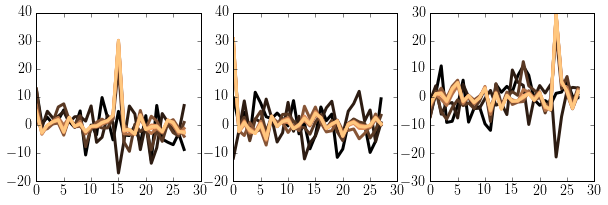

In [28]:
figure(figsize=(10,3))
cols = get_cmap('copper', n_steps)
for i in range(n_steps):
    subplot(131)
    plot(l1_coef_hist[i,:], lw=3, c=cols(i))
    subplot(132)
    plot(l2_coef_hist[i,:], lw=3, c=cols(i))
    subplot(133)
    plot(l3_coef_hist[i,:], lw=3, c=cols(i))
    
l1 = alph[np.argmax(np.abs(l1_coef_hist[-1,:]))]
l2 = alph[np.argmax(np.abs(l2_coef_hist[-1,:]))]
l3 = alph[np.argmax(np.abs(l3_coef_hist[-1,:]))]

print l1+l2+l3

In this plot you can see the convergence process ocurring. Each plot is showing the coefficients for the guess of each letter. The earliest iterations are in black and the later iterations are in copper. As the correct answer is inferred, these distributions become more and more peaked. Each iteration uses these distributions as the guess for the next iteration, and the peakier the distribution, the less noisy the decoding will be. 

## Decoding with interference noise

So we can perform the inference on a single word, but in order to infer the present-past relationships, we need to be able to handle interference noise from other words. Since the words are based on feature-representations, they have correlational structure that is complicated to tractably analzye. However, it is clear that with more iteration steps or more neurons in the network, the likelihood of convergence to the correct answer is higher. 

To begin, I will simply store a few three-letter words attached to unique keys in superposition in $\Omega$. Then I will decode one key-value pair by dereferencing the key and then use the resonance attractor to infer the letter sequence. This will be harder, but can be solved by increasing $N$ or increasing the number of iterations.

In [234]:
alph = 'abcdefghijklmnopqrstuvwxyz#.'

N = 2000
D = len(alph)

letter_vecs = 2 * (np.random.randn(D, N) < 0) - 1


word_key = 2 * (np.random.randn(N) < 0) - 1

ngram_strs = ['pax', 'max', 'the', 'run', 'ran', 'fun', 'fan', 'top', 'pop', 'off', 'cup', 'cap', 'rap', 'pup', 'pan', 'pun']
#ngram_strs = ['pax', 'max', 'the']
bound_vec = np.zeros(N)

for istr, ngram_str in enumerate(ngram_strs):
    vv = ngram_encode_cl(ngram_str, letter_vecs, alph)
    bound_vec += np.roll(word_key, istr) * vv

unbind_idx = 2
bound_vec = np.roll(word_key, unbind_idx) * bound_vec

l0_state = np.random.randn(N)
l1_state = np.random.randn(N)
l2_state = np.random.randn(N)
l3_state = np.random.randn(N)
l4_state = np.random.randn(N)

l1_state = np.dot(letter_vecs.T, np.dot(l1_state, letter_vecs.T))
l2_state = np.dot(letter_vecs.T, np.dot(l2_state, letter_vecs.T))
l3_state = np.dot(letter_vecs.T, np.dot(l3_state, letter_vecs.T))

l1_state = l1_state/norm(l1_state)
l2_state = l2_state/norm(l2_state)
l3_state = l3_state/norm(l3_state)


l0_state = letter_vecs[alph.find('#'), :]
l4_state = letter_vecs[alph.find('.'), :]


n_steps = 50

l1_coef_hist = np.zeros((n_steps, D))
l2_coef_hist = np.zeros((n_steps, D))
l3_coef_hist = np.zeros((n_steps, D))

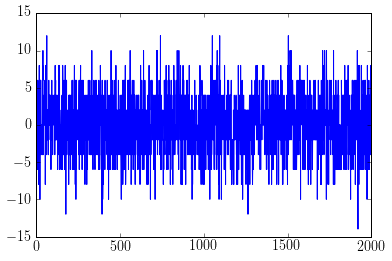

In [235]:
plot(bound_vec)

In [236]:
for i in range(n_steps):
    l1_coef_hist[i, :] = np.dot(letter_vecs, l1_state)
    l2_coef_hist[i, :] = np.dot(letter_vecs, l2_state)
    l3_coef_hist[i, :] = np.dot(letter_vecs, l3_state)
    
    ## Need to make sure that the largest absolute value is always positive,
    ## because the unbinding inference can flip 2 and be the same
    
    mx1idx = np.argmax(np.abs(l1_coef_hist[i,:]))
    l1_state *= np.sign(l1_coef_hist[i, mx1idx])
    mx2idx = np.argmax(np.abs(l2_coef_hist[i,:]))
    l2_state *= np.sign(l2_coef_hist[i, mx2idx])
    mx3idx = np.argmax(np.abs(l3_coef_hist[i,:]))
    l3_state *= np.sign(l3_coef_hist[i, mx3idx])
    
    
    l1d = (np.roll(bound_vec * l0_state * np.roll(l2_state, 2), -1) +
          bound_vec * np.roll(l2_state, 1) * np.roll(l3_state, 2)) / 2

    l2d = (np.roll(bound_vec * l0_state * np.roll(l1_state, 1), -2) +
            np.roll(bound_vec * l1_state * np.roll(l3_state, 2), -1) +
              bound_vec * np.roll(l3_state, 1) * np.roll(l4_state, 2)) / 3

    l3d = (np.roll(bound_vec * l2_state * np.roll(l4_state, 2), -1) +
           np.roll(bound_vec * l1_state * np.roll(l2_state, 1), -2)) / 2

    l1_state = np.dot(letter_vecs.T, np.dot(l1d, letter_vecs.T)/N)
    l2_state = np.dot(letter_vecs.T, np.dot(l2d, letter_vecs.T)/N)
    l3_state = np.dot(letter_vecs.T, np.dot(l3d, letter_vecs.T)/N)

    l1_state = l1_state/norm(l1_state)
    l2_state = l2_state/norm(l2_state)
    l3_state = l3_state/norm(l3_state)


the


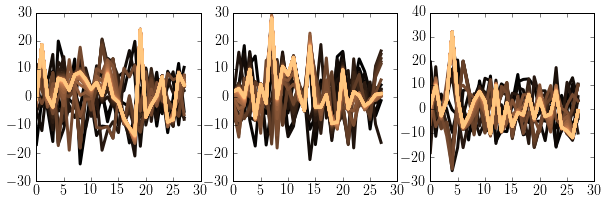

In [237]:
figure(figsize=(10,3))
cols = get_cmap('copper', n_steps)
for i in range(n_steps):
    subplot(131)
    plot(l1_coef_hist[i,:], lw=3, c=cols(i))
    subplot(132)
    plot(l2_coef_hist[i,:], lw=3, c=cols(i))
    subplot(133)
    plot(l3_coef_hist[i,:], lw=3, c=cols(i))
    
l1 = alph[np.argmax(np.abs(l1_coef_hist[-1,:]))]
l2 = alph[np.argmax(np.abs(l2_coef_hist[-1,:]))]
l3 = alph[np.argmax(np.abs(l3_coef_hist[-1,:]))]

print l1+l2+l3

## Resonance attractors that 'Explain Away'

With all of the variables solved-for in the resonance attractor, we can recreate the feature-representation and then compare the input to the inferred input. We can subtract off what we think we see from the actual input, and then maintain the past input in the local state. This has some potential advantages, such as cleaning up other channels and getting absolute values, but is more complicated. 

We can see that both methods can solve the problem, even with the non-linear sign function.

In [13]:
alph = 'abcdefghijklmnopqrstuvwxyz#.'

N = 1000
D = len(alph)

letter_vecs = 2 * (np.random.randn(D, N) < 0) - 1


ngram_str = 'pax'

bound_vec = ngram_encode_cl(ngram_str, letter_vecs, alph)


l0_state = np.random.randn(N)
l1_state = np.random.randn(N)
l2_state = np.random.randn(N)
l3_state = np.random.randn(N)
l4_state = np.random.randn(N)

l1_state = np.dot(letter_vecs.T, np.dot(l1_state, letter_vecs.T))
l2_state = np.dot(letter_vecs.T, np.dot(l2_state, letter_vecs.T))
l3_state = np.dot(letter_vecs.T, np.dot(l3_state, letter_vecs.T))

l1_state = l1_state/norm(l1_state)
l2_state = l2_state/norm(l2_state)
l3_state = l3_state/norm(l3_state)


l0_state = letter_vecs[alph.find('#'), :]
l4_state = letter_vecs[alph.find('.'), :]


n_steps = 14

l1_coef_hist = np.zeros((n_steps, D))
l2_coef_hist = np.zeros((n_steps, D))
l3_coef_hist = np.zeros((n_steps, D))

In [14]:
th_vec = bound_vec.copy()

for i in range(n_steps):
    l1_coef_hist[i, :] = np.dot(letter_vecs, l1_state)
    l2_coef_hist[i, :] = np.dot(letter_vecs, l2_state)
    l3_coef_hist[i, :] = np.dot(letter_vecs, l3_state)
    
    ## Need to make sure that the largest absolute value is always positive,
    ## because the unbinding inference can flip 2 and be the same
    
    mx1idx = np.argmax(np.abs(l1_coef_hist[i,:]))
    l1_state *= np.sign(l1_coef_hist[i, mx1idx])
    mx2idx = np.argmax(np.abs(l2_coef_hist[i,:]))
    l2_state *= np.sign(l2_coef_hist[i, mx2idx])
    mx3idx = np.argmax(np.abs(l3_coef_hist[i,:]))
    l3_state *= np.sign(l3_coef_hist[i, mx3idx])
    
    
    l1d = (np.roll(th_vec * l0_state * np.roll(l2_state, 2), -1) +
          th_vec * np.roll(l2_state, 1) * np.roll(l3_state, 2)) / 2

    l2d = (np.roll(th_vec * l0_state * np.roll(l1_state, 1), -2) +
            np.roll(th_vec * l1_state * np.roll(l3_state, 2), -1) +
              th_vec * np.roll(l3_state, 1) * np.roll(l4_state, 2)) / 3

    l3d = (np.roll(th_vec * l2_state * np.roll(l4_state, 2), -1) +
           np.roll(th_vec * l1_state * np.roll(l2_state, 1), -2)) / 2

    l1_state = 3.5*np.dot(letter_vecs.T, np.dot(l1d, letter_vecs.T)/N) + 1.0*l1_state
    l2_state = 3.5*np.dot(letter_vecs.T, np.dot(l2d, letter_vecs.T)/N) + 1.0*l2_state
    l3_state = 3.5*np.dot(letter_vecs.T, np.dot(l3d, letter_vecs.T)/N) + 1.0*l3_state

    
    l1_state = l1_state/norm(l1_state)
    l2_state = l2_state/norm(l2_state)
    l3_state = l3_state/norm(l3_state)
    
    bv = (l0_state * np.roll(l1_state,1) * np.roll(l2_state,2) 
          +l1_state * np.roll(l2_state,1) * np.roll(l3_state,2) 
          +l2_state * np.roll(l3_state,1) * np.roll(l4_state,2) )    
    bv = 2*(bv > 0) - 1
    
    th_vec = bound_vec - bv
    
    



pax


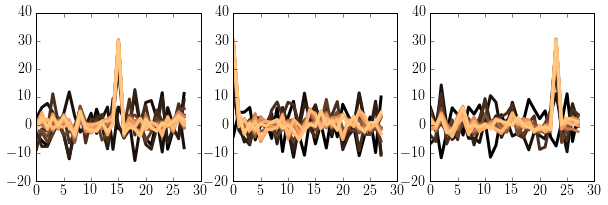

In [15]:
figure(figsize=(10,3))
cols = get_cmap('copper', n_steps)
for i in range(n_steps):
    subplot(131)
    plot(l1_coef_hist[i,:], lw=3, c=cols(i))
    subplot(132)
    plot(l2_coef_hist[i,:], lw=3, c=cols(i))
    subplot(133)
    plot(l3_coef_hist[i,:], lw=3, c=cols(i))
    
    
l1 = alph[np.argmax(np.abs(l1_coef_hist[-1,:]))]
l2 = alph[np.argmax(np.abs(l2_coef_hist[-1,:]))]
l3 = alph[np.argmax(np.abs(l3_coef_hist[-1,:]))]

print l1+l2+l3

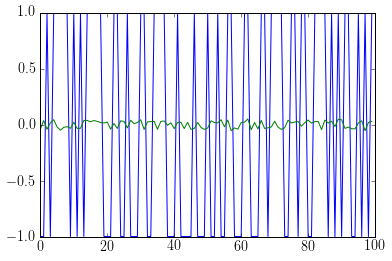

In [16]:
plot(bound_vec[100:200])
plot(l1_state[100:200])

Since part of our encoding function uses a non-linearity -- clipping -- this is not sensitive to the absolute magnitude of the code vectors, only their relative magnitude. This means we cannot recover the absolute magnitudes of each entry. With no such non-linear function, we could recover the absolute magnitudes using the explaining away method.

## Store all states in same hypervector

Previously, we built an algorithm that can only decode a three-letter word. We used an indpendent hypervector to store each letter that was being inferred. Here, we will attempt to use a single hypervector that can infer all the letters of a word up to a maximum length. The letters will be stored in the hypervector using trajectory association, and a single hypervector will maintain the entire letter sequence in superposition while also performing the inference. 



In [345]:
alph = 'abcdefghijklmnopqrstuvwxyz#.'

N = 2000
D = len(alph)

letter_vecs = 2 * (np.random.randn(D, N) < 0) - 1


ngram_str = 'pax'

bound_vec = ngram_encode_cl(ngram_str, letter_vecs, alph)

# so to have them in superposition, we have the resonance matrix appear as a letter sequence
lvs = np.vstack((letter_vecs, np.roll(letter_vecs, 1, axis=1), np.roll(letter_vecs, 2, axis=1)))

l_state = np.random.randn(N)

l_state = np.dot(lvs.T, np.dot(l_state, lvs.T))

l_state = l_state/norm(l_state)

l0_state = letter_vecs[alph.find('#'), :]
l4_state = letter_vecs[alph.find('.'), :]


n_steps = 60

l1_coef_hist = np.zeros((n_steps, D))
l2_coef_hist = np.zeros((n_steps, D))
l3_coef_hist = np.zeros((n_steps, D))

In [346]:
for i in range(n_steps):
    l1_coef_hist[i, :] = np.dot(letter_vecs, l_state)
    l2_coef_hist[i, :] = np.dot(letter_vecs, np.roll(l_state, -1))
    l3_coef_hist[i, :] = np.dot(letter_vecs, np.roll(l_state, -2))

    ## keeping everything positive isn't as trivial
    mx1idx = np.argmax(np.abs(l1_coef_hist[i,:]))
    l_state *= np.sign(l1_coef_hist[i, mx1idx])
    mx2idx = np.argmax(np.abs(l2_coef_hist[i,:]))
    l_state *= np.sign(l2_coef_hist[i, mx2idx])
    mx3idx = np.argmax(np.abs(l3_coef_hist[i,:]))
    l_state *= np.sign(l3_coef_hist[i, mx3idx])
    
    
    ld = ((np.roll(bound_vec * l0_state * l_state, -1) +
          bound_vec * np.roll(l_state, -1) * np.roll(l_state, 1)) / 2

         + (np.roll(bound_vec * l0_state * np.roll(l_state, 1), -1) +
            + bound_vec * l_state * l_state
            + np.roll(bound_vec * np.roll(l_state, -1) * np.roll(l4_state, 2), 1) / 3

         + (np.roll(bound_vec * np.roll(l_state, -1) * np.roll(l4_state, 2), 1)
            + np.roll(bound_vec * l_state * np.roll(l_state, -1), 0)) / 2))

    l_state = np.dot(lvs.T, np.dot(ld, lvs.T))
    l_state = l_state / norm(l_state)
    

pax


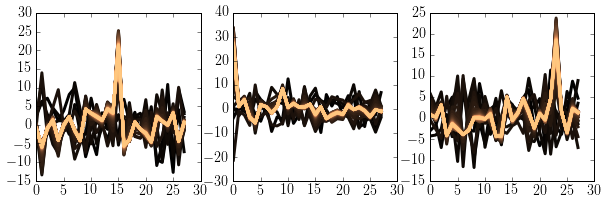

In [347]:
figure(figsize=(10,3))
cols = get_cmap('copper', n_steps)
for i in range(n_steps):
    subplot(131)
    plot(l1_coef_hist[i,:], lw=3, c=cols(i))
    subplot(132)
    plot(l2_coef_hist[i,:], lw=3, c=cols(i))
    subplot(133)
    plot(l3_coef_hist[i,:], lw=3, c=cols(i))
    
    
l1 = alph[np.argmax(np.abs(l1_coef_hist[-1,:]))]
l2 = alph[np.argmax(np.abs(l2_coef_hist[-1,:]))]
l3 = alph[np.argmax(np.abs(l3_coef_hist[-1,:]))]

print l1+l2+l3